# Calculate the glass transition temperature, $T_g$, of an amorphous polymer or molecular system using cloud computing at nanoHUB.org

*Benjamin Haley, Lorena Alzate-Vargas, Martin Hunt, Chunyu Li, and Alejandro Strachan* <br>
*Purdue University*

### Main steps to calculate Tg:
1. Build an atomistic model for your molecular material using Polymer Modeler (nanohub.org/tools/polymod)
2. Relax the structure using molecular dynamics (LAMMPS) at a relatively high temperature (above the expected $T_g$)
3. Use molecular dynamics to cool down your system
4. We will identify $T_g$ as a change in slope. Fit the density-temperature data using bilinear and hyperbolic methods and extract $T_g$ 

### Further reading
- *Uncertainties on predictions of thermo-physical properties of thermoplastic polymers via molecular dynamics*, Alzate-Vargas, Lorena; Fortunato, Michael; Haley, Benjamin; Li, Chunyu; Colina, Coray; Strachan, Alejandro, Mod. Sim. Mat. Sci. Eng. (2018).
- *Atomistic simulations of amorphous polymers in the cloud with PolymerModeler*, Haley BP, Li C, Wilson N, Jaramillo E, Strachan A.  arXiv preprint arXiv:1503.03894. 2015 Mar 12.

In [1]:
# System setup
import sys, os, tempfile, numpy as np
import hublib.rappture as rappture
sys.path.append('/apps/share64/debian7/ipynb_tools')
import hubwf

<IPython.core.display.Javascript object>

### Step 1. Build an atomistic model of your polymer or molecular system

In [2]:
# Create an interface to the PolymerModeler tool
task = rappture.Tool('polymod')

In [3]:
# This variable selects the source of the monomer molecule(s).  By default, we use monomers already defined in the PolymerModeler tool
# on nanoHUB, but we can also download molecular structure files from ChemSpider.
monomer_source = 'polymod'
#monomer_source = 'chemspider'

In [4]:
# Select the monomer molecule in PolymerModeler
if monomer_source == 'polymod':
    task.set_input('Polymer', 'PMMA (atactic)')

In [5]:
# Select the monomer molecule from ChemSpider
if monomer_source == 'chemspider':
    chemspider_id = '10571'  # PMMA
    pdbfile = hubwf.get_chemspider_structure(chemspider_id)
    # Use the downloaded monomer molecule with PolymerModeler
    task.set_input('Monomer format', 'pdb')
    with open(pdbfile, 'r') as f:
        pdbstr = f.read()
    task.set_input('Monomer atoms', pdbstr)
    task.set_input('Head atom', 12)
    task.set_input('Tail atom', 8)
    # Visualize the structure
    v = hubwf.view_ball_stick(pdbfile)
    v.add_representation('label', label_type='atomindex')
    display(v)

Run PolymerModeler to pack chains/molecules into a box. This step builds the initial system and writes the input files for LAMMPS to relax the system (not the  $T_g$ calculation)

In [6]:
# Here you need to specify the size of the system and the relaxation parameters for LAMMPS

# Set the length of the chains (monomers per chain)
task.set_input('Monomers per chain', 60)

# Set the number of chains
task.set_input('Number of chains', 10)   

# Use sp3-sp3 torsion energies
task.set_input('Covalent torsion energies', 'sp3-sp3')

# Rotate all torsions along the backbone of chains to pack them as they are built
task.set_input('Torsion selection', 'all')

# Set the build temperature
task.set_input('Monte Carlo temperature', '800K') 

# Have the tool generate input files for LAMMPS
task.set_input('Simulation choice', 'LAMMPS input files only')

# Generate LAMMPS commands to relax the structure
task.set_input('Minimization levels', 3)
task.set_input('Minimization steps', 5000)

# Generate LAMMPS commands to thermalize at 800K

# task.set_input('Ensemble', 'npt')
# that does not work because there are two inputs labelled 'Ensemble'.  We need to use
# specifically set the one we want using the lower-level API.
task['input.phase(simulation_phase).group(lammps_group).group(drivers).choice(ensemble)'] = 'npt'

task.set_input('Number of MD steps', 20000)
task.set_input('Temperature', 800)

# for testing
task['input.phase(structure_phase).group(build_polymer).group(advanced_tab).integer(rng_seed)'] = 42

# Run the tool
task.run(verbose=True)
print 'Finished running PolymerModeler'

/bin/sh -l -c "TOOL_PARAMETERS=/home/nanohub/shen276/data/sessions/1663711/3613/driver.hz /apps/polymod/current/middleware/invoke -d /home/nanohub/shen276/data/sessions/1663711/3613"
Finished running PolymerModeler


In [7]:
# View the initial structure built by PolymerModeler
task.get_output('Built structures, unwrapped').plot()


NGLWidget()

### Step 2. Relax your system at a high temperature

In [8]:
# Relax and thermalize the initial structure built by PolymerModeler
import hublib.use
%use lammps-11Aug17

nodes = 4
walltime = '0:40:00'
datafile = 'polymer_relax.data'
with open(datafile, 'w') as f:
    f.write(task.get_output('LAMMPS data file (from builder, before MD)').get_text())
infile = 'lammps_relax.in'
with open(infile, 'w') as f:
    f.write(task.get_output('LAMMPS input file').get_text())

!submit -n $nodes -w $walltime -i $datafile lammps-11Aug17-parallel -in $infile

Run 7870272 registered 1 job instance. Fri Jul 31 10:08:03 2020
Run 7870272 instance 1 released for submission. Fri Jul 31 10:08:28 2020
(2656803) Job Submitted at standby@brown Fri Jul 31 10:08:33 2020
(2656803) Simulation Pending at standby@brown Fri Jul 31 10:09:28 2020
(2656803) Simulation Running at standby@brown Fri Jul 31 10:11:43 2020
(2656803) Simulation Running at standby@brown Fri Jul 31 10:17:19 2020
(2656803) Simulation Running at standby@brown Fri Jul 31 10:23:19 2020
(2656803) Simulation Running at standby@brown Fri Jul 31 10:29:59 2020
(2656803) Simulation Running at standby@brown Fri Jul 31 10:35:19 2020
(2656803) Simulation Done at standby@brown Fri Jul 31 10:43:21 2020


### Step 3. Cool down your system.
- Remember we will extract $T_g$ from the density-temperature data from these simulations
- Cooling rates should be as slow as possible (by MD standards)

In [ ]:
# Cool down the structure with LAMMPS
infile = 'lammps_cool.in'
T_steps = 25000
lammps_input = """
read_restart      restart.lammps

neighbor          2.0 bin
thermo_style      custom temp density vol etotal ke pe ebond eangle edihed eimp evdwl ecoul elong press pxx pyy pzz pxy pxz pyz lx ly lz
thermo            100
thermo_modify     flush yes line multi format float %16.6g

timestep          4
neigh_modify      every 1 delay 5
kspace_style      pppm 1e-4
run_style         respa 3 2 2 bond 1 pair 2 kspace 3
velocity          all create 800.0 1214556 mom yes rot yes dist gaussian

# Loop
variable          i loop 26
label             loopa
reset_timestep    0
variable          T equal 800+($i-1)*(-20)

fix               1 all npt temp $T $T 100.0 iso 1.0 1.0 1000.
dump              2 all custom 500 strcool_$TK.dump id type x y z
run               {0}
write_data        str_cool$TK.data
unfix             1
undump            2
next              i
jump              {1} loopa
""".format(T_steps, infile)

with open(infile, 'w' ) as f:
    f.write(lammps_input)
walltime = '15:00:00'

!submit -n $nodes -w $walltime -i restart.lammps lammps-11Aug17-parallel -in $infile

Run 7870325 registered 1 job instance. Fri Jul 31 11:03:49 2020
Run 7870325 instance 1 released for submission. Fri Jul 31 11:04:14 2020
(2204599) Job Submitted at ncn@rice Fri Jul 31 11:04:18 2020
(2204599) Simulation Running at ncn@rice Fri Jul 31 11:05:13 2020
(2204599) Simulation Running at ncn@rice Fri Jul 31 11:10:49 2020
(2204599) Simulation Running at ncn@rice Fri Jul 31 11:16:49 2020
(2204599) Simulation Running at ncn@rice Fri Jul 31 11:23:30 2020
(2204599) Simulation Running at ncn@rice Fri Jul 31 11:28:50 2020
(2204599) Simulation Running at ncn@rice Fri Jul 31 11:36:51 2020
(2204599) Simulation Running at ncn@rice Fri Jul 31 11:42:11 2020


### Step 4. Analyze your MD, extract $T_g$ and plot your data

Tg from bilinear fit: 460 Error: 11.3
Tg from hyperbola fit: 453 Error: 28.56


<IPython.core.display.Javascript object>


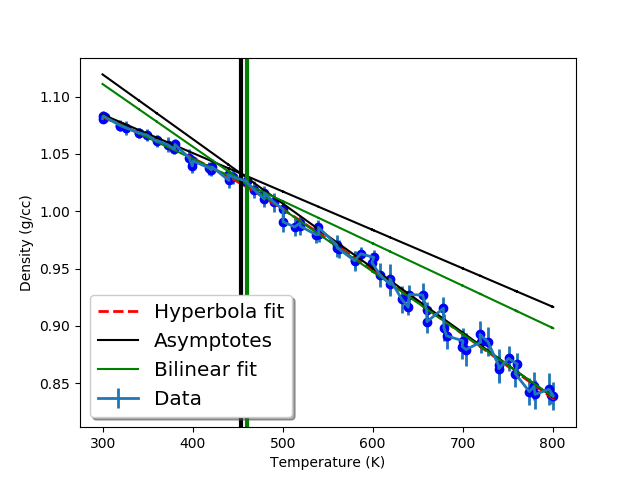

In [10]:
# Extract the density and temperature data from LAMMPS output; find Tg
from Tgcalc import getVDT, getVDTdata, bilinear, hyperbola
%matplotlib notebook
import matplotlib.pyplot as plt
T_steps = 13000


# Calculate Tg
getVDT('log.lammps', T_steps)
T, rho, err = getVDTdata('log.rec_VDT')
prb = bilinear(T,rho,err)
prh = hyperbola(T,rho,err,prb)
print 'Tg from bilinear fit:', int(prb[0]), 'Error:', np.round(prb[5],2)
print 'Tg from hyperbola fit:', int(prh[0]), 'Error:', np.round(prh[1],2)

T, rho, error, fit, alow, ahigh = np.loadtxt('log.rec_VDT.dat', unpack=True)
def fl(T):
    return prb[2]*T+prb[1]
def fh(T):
    return prb[4]*T+prb[3]

# Plot data and results
fig, ax = plt.subplots()
ax.errorbar(T, rho, yerr=error, linewidth=2.0, label='Data')
ax.plot(T, rho, 'bo')
ax.plot(T, fit, 'r--', linewidth=2.0, label='Hyperbola fit')
ax.plot(T, alow, 'k', linewidth=1.5) 
ax.plot(T, ahigh, 'k', linewidth=1.5, label='Asymptotes')
ax.plot(T, fl(T), 'g', linewidth=1.5)
ax.plot(T, fh(T), 'g', linewidth=1.5, label='Bilinear fit')
plt.axvline(x=prb[0], color='g', linewidth=3.0)
plt.axvline(x=prh[0], color='k', linewidth=3.0)
ax.set(xlabel='Temperature (K)', ylabel='Density (g/cc)')
legend = ax.legend(loc='lower left', shadow=True, fontsize='x-large')
plt.show()